In [1]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
def rollingWindow(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [3]:
val = pd.read_csv('./data/validation/REFERENCE.csv', names=['id', 'type'])
val['fname'] = './data/validation/' + val.id
val['noisy'] = val.type == '~'

In [5]:
MIN_BPM = 30
MIN_FREQ = 300  # from inspection of '.hea' content
SAMPLE_WINDOW = int(60 / MIN_BPM * MIN_FREQ)
FIRST_WINDOW = int(SAMPLE_WINDOW / 2)  # avoid artifacts in the beginning of signal

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.load_weights('./mydata/ecgV1/0025.ckpt')

The below function receives the filename of the signal and will plot the signal along with a 1/0 line indicating sections of the signal that have noise (1) or no noise(0). Example uses follow.

In [38]:
def check_signal(fname):
    data, _ = wfdb.rdsamp(fname)
    sgnl = data[:, 0]
    sgnl_slices = rollingWindow(sgnl, SAMPLE_WINDOW)
    noisy_flag = model.predict(sgnl_slices[...,np.newaxis])

    flags = np.zeros(len(sgnl))
    for idx, noisy in enumerate(noisy_flag.argmax(1)):
        if noisy:
            flags[idx:idx+SAMPLE_WINDOW] = 1
    
    _, axs = plt.subplots(2)
    axs[0].plot(sgnl)
    axs[1].plot(flags)

263/263 [==============================] - 2s 8ms/step


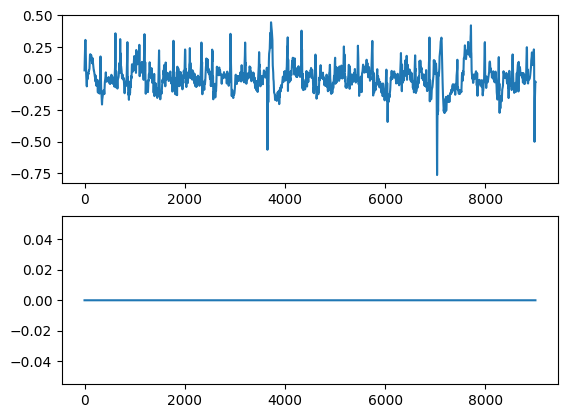

In [39]:
check_signal(val[val.noisy == True].fname.values[0])
# In this example we have a noisy signal that could not be identified at all.

  1/148 [..............................] - ETA: 3s

148/148 [==============================] - 1s 9ms/step


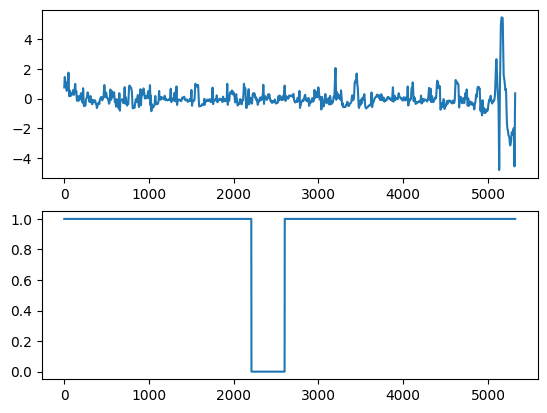

In [40]:
check_signal(val[val.noisy == True].fname.values[1])
# In this noisy example, almost the entire signal was identified as noisy.

  1/100 [..............................] - ETA: 2s

100/100 [==============================] - 1s 8ms/step


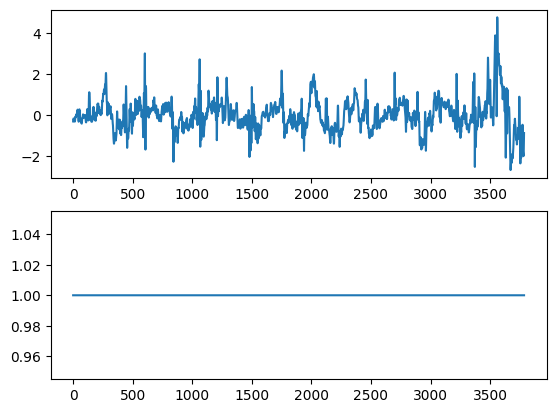

In [42]:
check_signal(val[val.noisy == True].fname.values[2])
# In this noisy example, the entire signal was identified as noisy.

172/172 [==============================] - 2s 9ms/step


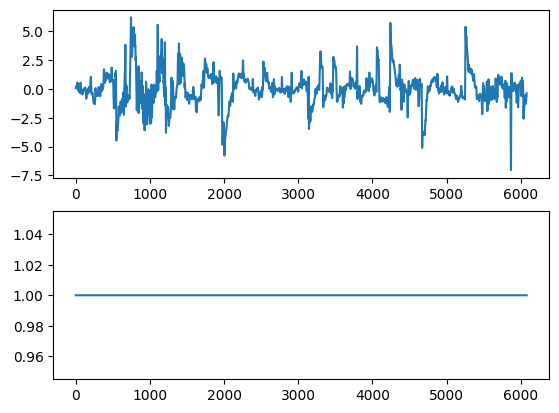

In [45]:
check_signal(val[val.noisy == True].fname.values[20])
# In this noisy example, the entire signal was identified as noisy.

263/263 [==============================] - 2s 8ms/step


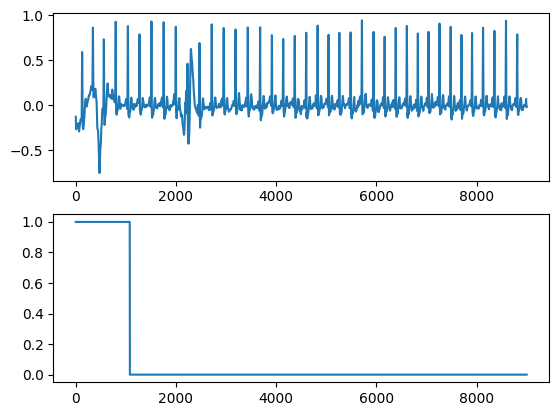

In [46]:
check_signal(val[val.noisy == False].fname.values[0])
# In this clean example, the begining was identified as noisy,
# but a section in the middle was missed.

263/263 [==============================] - 2s 8ms/step


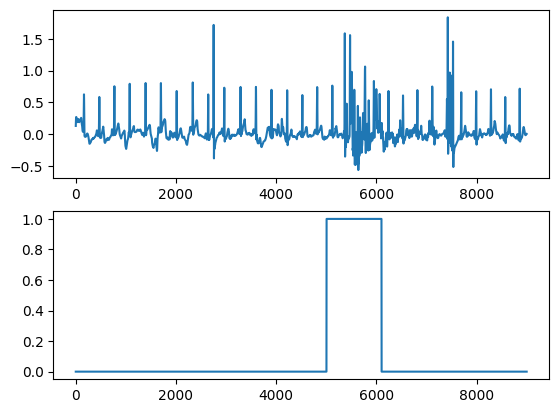

In [47]:
check_signal(val[val.noisy == False].fname.values[1])
# In this clean example, the long noisy subsignal was identified,
# but some other shorter segments were missed.

544/544 [==============================] - 4s 8ms/step


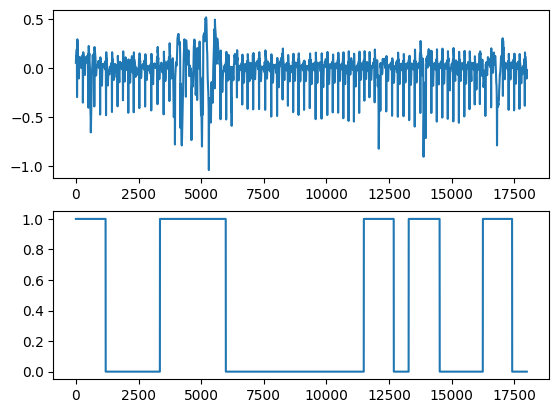

In [48]:
check_signal(val[val.noisy == False].fname.values[2])
# In this clean example, all the noisy subsignals were identified.

125/125 [==============================] - 1s 8ms/step


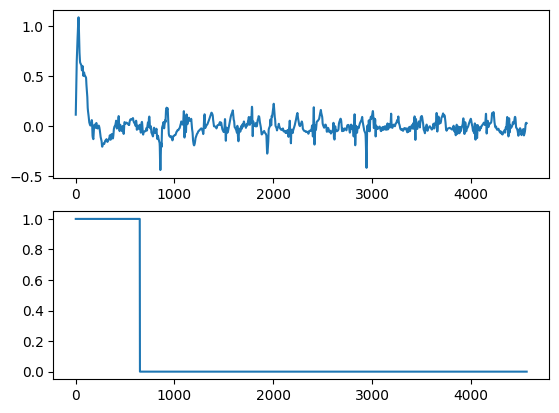

In [49]:
check_signal(val[val.noisy == False].fname.values[200])
# In this clean example, the noisy subsignal in the beginning was identified,
# but it is possible that other sections should have been, as well - not sure.

263/263 [==============================] - 2s 8ms/step


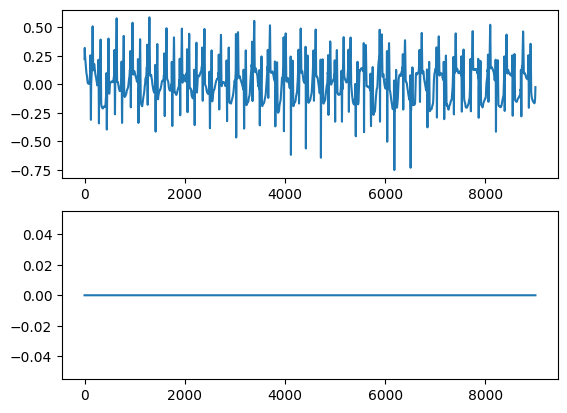

In [50]:
check_signal(val[val.noisy == False].fname.values[250])
# In this clean example, nothing was identified as noisy - not sure
# if this is correct, since I would classify the whole signal as noise.

263/263 [==============================] - 2s 8ms/step


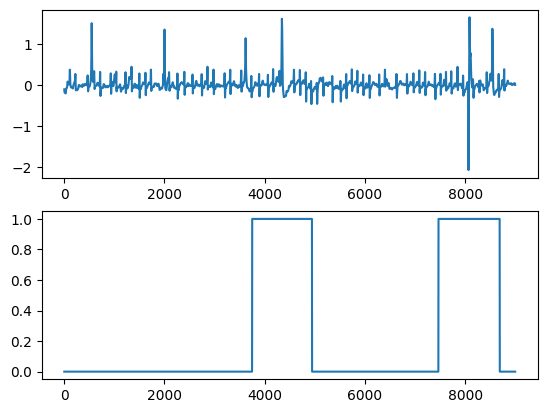

In [52]:
check_signal(val[val.noisy == False].fname.values[155])
# In this clean example, we clearly see an anomaly on the 'S'
# part of the beat in the first sections, and also some noise
# in the second section.